In [1]:
import pandas as pd
df = pd.read_csv("Tweets.csv")

In [2]:
review_df = df[['text','airline_sentiment']]

print(review_df.shape)
review_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [3]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [4]:
review_df = review_df[review_df['airline_sentiment'] != 'neutral']

print(review_df.shape)
review_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [5]:
review_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

In [7]:
tweet = review_df.text.values

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(tweet)

In [9]:
vocab_size = len(tokenizer.word_index) + 1

In [10]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [12]:
print(tweet)

["@VirginAmerica plus you've added commercials to the experience... tacky."
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'
 "@VirginAmerica and it's a really big bad thing about it" ...
 '@AmericanAir thank you we got on a different flight to Chicago.'
 "@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc"
 "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"]


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding


embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

In [14]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 54s 172ms/step - loss: 0.4002 - accuracy: 0.8355 - val_loss: 0.2202 - val_accuracy: 0.9125
Epoch 2/5
289/289 [==============================] - 46s 161ms/step - loss: 0.2250 - accuracy: 0.9143 - val_loss: 0.1658 - val_accuracy: 0.9398
Epoch 3/5
289/289 [==============================] - 47s 164ms/step - loss: 0.1649 - accuracy: 0.9391 - val_loss: 0.1654 - val_accuracy: 0.9402
Epoch 4/5
289/289 [==============================] - 47s 164ms/step - loss: 0.1376 - accuracy: 0.9488 - val_loss: 0.1729 - val_accuracy: 0.9381
Epoch 5/5
289/289 [==============================] - 47s 163ms/step - loss: 0.1138 - accuracy: 0.9586 - val_loss: 0.1680 - val_accuracy: 0.9398


In [15]:
model.save('Model.h5')

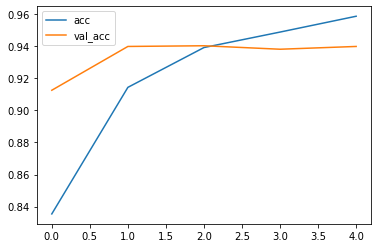

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

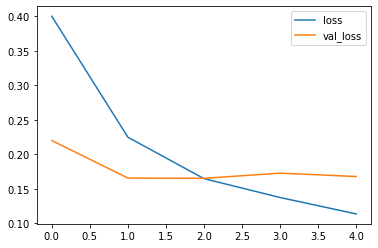

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

In [18]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])
    return sentiment_label[1][prediction]


test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 360ms/step
Predicted label:  positive
1/1 [==============================] - 0s 63ms/step
Predicted label:  negative


'negative'

In [19]:
test_sentence3 = 'This is the best mobile I have ever seen!!!'
predict_sentiment(test_sentence3)

1/1 [==============================] - 0s 40ms/step
Predicted label:  positive


'positive'

In [20]:
def predict_sentiment1(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    return sentiment_label[1][prediction]

In [21]:
predict_sentiment('This is the best mobile I have ever seen!!!')

1/1 [==============================] - 0s 35ms/step
Predicted label:  positive


'positive'

In [22]:
predict_sentiment1('This is the best mobile I have ever seen!!!')

1/1 [==============================] - 0s 30ms/step


'positive'

In [23]:
test_sentence5 = 'This product was Not upto the mark'
predict_sentiment(test_sentence5)

1/1 [==============================] - 0s 27ms/step
Predicted label:  negative


'negative'

In [24]:
# pickle.dump(sentiment_label,open('sentiment_label.pkl','wb'))